In [2]:
!pip install sklearn-crfsuite


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.9 MB/s eta 0:00:00


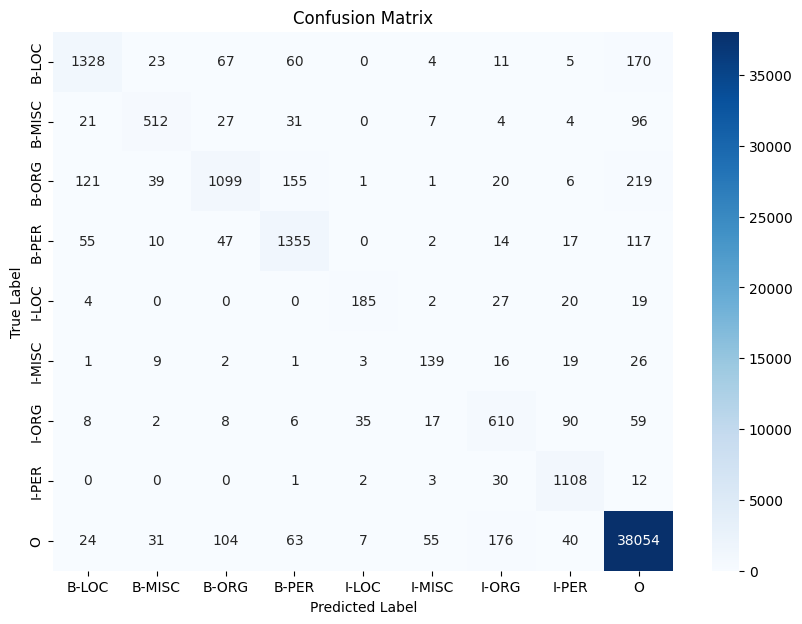

              precision    recall  f1-score   support

       B-LOC       0.85      0.80      0.82      1668
      B-MISC       0.82      0.73      0.77       702
       B-ORG       0.81      0.66      0.73      1661
       B-PER       0.81      0.84      0.82      1617
       I-LOC       0.79      0.72      0.76       257
      I-MISC       0.60      0.64      0.62       216
       I-ORG       0.67      0.73      0.70       835
       I-PER       0.85      0.96      0.90      1156
           O       0.98      0.99      0.98     38554

    accuracy                           0.95     46666
   macro avg       0.80      0.78      0.79     46666
weighted avg       0.95      0.95      0.95     46666

All predictions match the true labels:  False


In [6]:
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
import sklearn_crfsuite
from sklearn_crfsuite import CRF

# Set the path to your dataset in Google Colab
data_path = '/home'  # Adjust this path if needed
train_file = os.path.join(data_path, 'train.txt')
test_file = os.path.join(data_path, 'test.txt')

# Function to load CoNLL formatted data
def load_conll_data(file_path):
    sentences = []
    with open(file_path, 'r') as file:
        current_sentence = []
        for line in file:
            if line.strip():  # If the line is not empty
                parts = line.strip().split()
                current_sentence.append((parts[0], parts[-1]))  # (word, label)
            else:  # End of a sentence
                if current_sentence:
                    sentences.append(current_sentence)
                    current_sentence = []
    return sentences

# Load training and test data
train_sentences = load_conll_data(train_file)
test_sentences = load_conll_data(test_file)

# Feature extraction function
def extract_features(sentences):
    features = []
    for sentence in sentences:
        sentence_features = []
        for i, (word, _) in enumerate(sentence):
            word_features = {
                'word.lower()': word.lower(),
                'word[-3:]': word[-3:],
                'word[-2:]': word[-2:],
                'word.isupper()': word.isupper(),
                'word.istitle()': word.istitle(),
                'word.isdigit()': word.isdigit(),
            }
            if i > 0:
                word_features['prev.word.lower()'] = sentence[i - 1][0].lower()
            else:
                word_features['prev.word.lower()'] = ''

            if i < len(sentence) - 1:
                word_features['next.word.lower()'] = sentence[i + 1][0].lower()
            else:
                word_features['next.word.lower()'] = ''

            sentence_features.append(word_features)
        features.append(sentence_features)
    return features

# Extract features and labels
X_train = extract_features(train_sentences)
y_train = [ [label for _, label in sentence] for sentence in train_sentences ]
X_test = extract_features(test_sentences)
y_test = [ [label for _, label in sentence] for sentence in test_sentences ]

# Train the CRF model
crf = CRF(algorithm='lbfgs', max_iterations=100, all_possible_transitions=True)
crf.fit(X_train, y_train)

# Make predictions
y_pred = crf.predict(X_test)

# Flatten the lists for confusion matrix calculation
true_labels = [label for sentence in y_test for label in sentence]
predicted_labels = [label for sentence in y_pred for label in sentence]

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=np.unique(true_labels))

# Display confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(cm, classes=np.unique(true_labels))

# Print classification report
print(classification_report(true_labels, predicted_labels))

# Check if test set and predictions are the same
# same = true_labels == predicted_labels # This comparison returns a single boolean (False in this case)
same = [a == b for a, b in zip(true_labels, predicted_labels)]  # Compare element-wise and create a list of booleans
print("All predictions match the true labels: ", all(same))


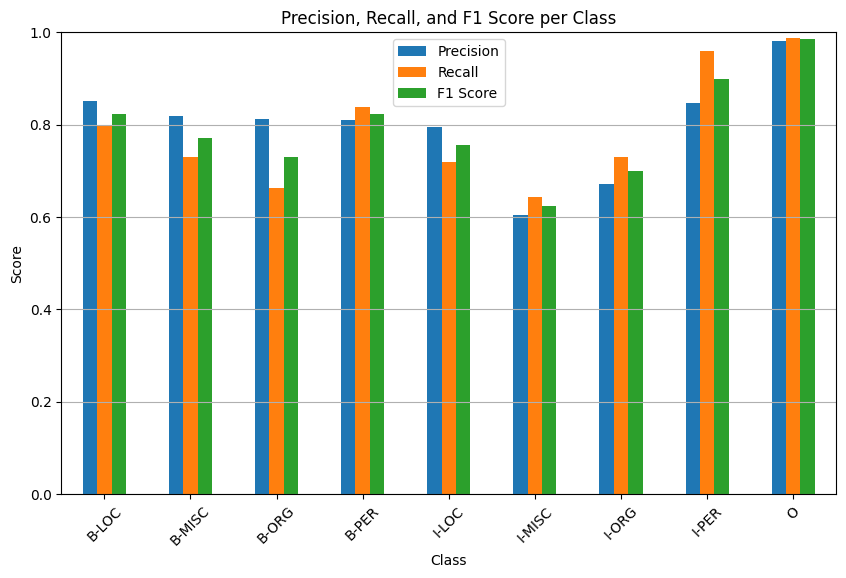

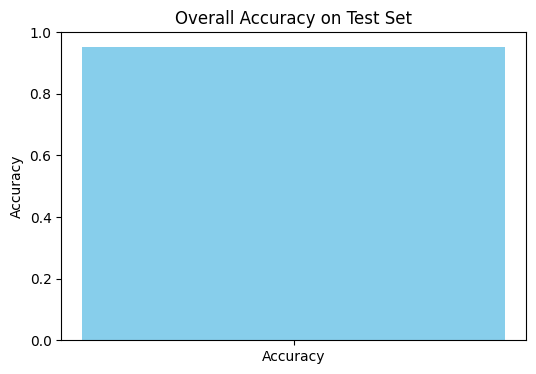

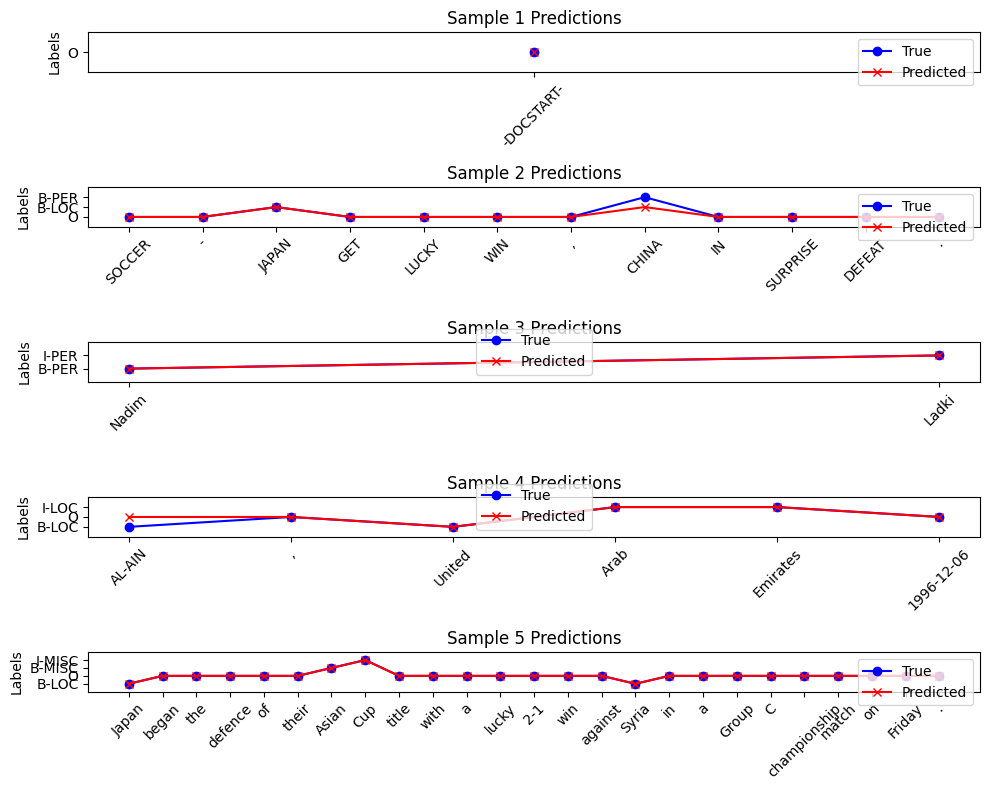

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

# Function to plot precision, recall, and F1 score for each class
def plot_classification_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=np.unique(y_true))
    classes = np.unique(y_true)

    metrics_df = pd.DataFrame({
        'Class': classes,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    metrics_df.set_index('Class', inplace=True)
    metrics_df.plot(kind='bar', figsize=(10, 6))
    plt.title('Precision, Recall, and F1 Score per Class')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.show()

# Plot accuracy for test set
def plot_accuracy(y_true, y_pred):
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    plt.figure(figsize=(6, 4))
    plt.bar(['Accuracy'], [accuracy], color='skyblue')
    plt.title('Overall Accuracy on Test Set')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

# Sample predictions plot
def plot_sample_predictions(sentences, y_true, y_pred, num_samples=5):
    plt.figure(figsize=(10, 8))
    for i, sentence in enumerate(sentences[:num_samples]):
        true_labels = [label for _, label in sentence]
        predicted_labels = y_pred[i]

        plt.subplot(num_samples, 1, i + 1)
        plt.plot(range(len(sentence)), true_labels, marker='o', label='True', color='blue')
        plt.plot(range(len(sentence)), predicted_labels, marker='x', label='Predicted', color='red')
        plt.title(f'Sample {i + 1} Predictions')
        plt.xticks(range(len(sentence)), [word for word, _ in sentence], rotation=45)
        plt.ylabel('Labels')
        plt.ylim(-1, len(np.unique(true_labels)))  # Adjust as needed for label visibility
        plt.legend()

    plt.tight_layout()
    plt.show()

# After you make predictions with your CRF model, add these plots
plot_classification_metrics(true_labels, predicted_labels)
plot_accuracy(true_labels, predicted_labels)
plot_sample_predictions(test_sentences, y_test, y_pred)
